In [2]:
"""Do advanced players choose more risky chess openings than novices? 

H0: Players of all ELO ratings choose openings of equal average risk level.

H1: Players with higher ratings choose lower-risk openings compared to players with a lower rating. """


'Do advanced players choose more risky chess openings than novices? \n\nH0: Players of all ELO ratings choose openings of equal average risk level.\n\nH1: Players with higher ratings choose lower-risk openings compared to players with a lower rating. '

In [3]:
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import numpy as np


In [4]:
chess_games1 = pd.read_csv("/Users/tonyvo/Desktop/SDA/final/Dataset/chess_games_risk_part1.csv")
chess_games2 = pd.read_csv("/Users/tonyvo/Desktop/SDA/final/Dataset/chess_games_risk_part2.csv")

df = pd.concat([chess_games1, chess_games2], ignore_index=True)  

keep = ["event","white_rating","black_rating","mean_risk"] # relevant columns for this hypothesis
df = df[keep]

ELO_MIN, ELO_MAX, BIN_W = 750, 2900, 50 # taken from data summary
elo_bins = np.arange(ELO_MIN, ELO_MAX + BIN_W, BIN_W)

df["elo_bin"] = pd.cut(df["white_rating"], bins=elo_bins, include_lowest=True) # group by elo bins to reduce amount of data processed


print("bins defined:", len(elo_bins) - 1) # total bins defined
print("n bins:", df["elo_bin"].nunique())
print(df["elo_bin"].value_counts().sort_index().head())
print(df["elo_bin"].value_counts().sort_index().tail())

df_c = df[df["event"] == 'c'].copy() # classical
df_b = df[df["event"] == 'b'].copy() # blitz

print("classical bins used:", df_c["elo_bin"].nunique())
print("blitz bins used:", df_b["elo_bin"].nunique())


bins defined: 43
n bins: 43
elo_bin
(749.999, 800.0]      49
(800.0, 850.0]       165
(850.0, 900.0]       487
(900.0, 950.0]      1013
(950.0, 1000.0]     2347
Name: count, dtype: int64
elo_bin
(2650.0, 2700.0]    235
(2700.0, 2750.0]     59
(2750.0, 2800.0]     24
(2800.0, 2850.0]     12
(2850.0, 2900.0]      1
Name: count, dtype: int64
classical bins used: 40
blitz bins used: 43


In [5]:
"""The range between minimmum and maximum is 2900 - 750 = 2150. 

2150/50 = 43 bins

Classical covers lower range of ELOs than blitz therefore classical has less bins."""

'The range between minimmum and maximum is 2900 - 750 = 2150. \n\n2150/50 = 43 bins\n\nClassical covers lower range of ELOs than blitz therefore classical has less bins.'

In [6]:
cols = ["white_rating", "black_rating", "mean_risk"]
print(df[cols].describe().T)

                  count         mean         std    min          25%  \
white_rating  2304171.0  1709.546896  254.685133  765.0  1534.000000   
black_rating  2304171.0  1708.141819  255.518850  728.0  1533.000000   
mean_risk     2304171.0    28.353142   19.413607    0.0    14.107542   

                      50%          75%     max  
white_rating  1708.000000  1878.000000  2901.0  
black_rating  1706.000000  1877.000000  2903.0  
mean_risk       24.701339    35.487561   100.0  


In [7]:
"""To get an idea of what the distribution between ELOs and opening risk looks like. We look at a histogram of ELOs 
and against opening risk. Its important to keep in mind that it only measures the white's opening and white's risk level. This 
still makes our dataset valid because White is not a special subset, its just everyone half of the time. We will first start with 
classical games, disregarding for time pressures."""

"To get an idea of what the distribution between ELOs and opening risk looks like. We look at a histogram of ELOs \nand against opening risk. Its important to keep in mind that it only measures the white's opening and white's risk level. This \nstill makes our dataset valid because White is not a special subset, its just everyone half of the time. We will first start with \nclassical games, disregarding for time pressures."

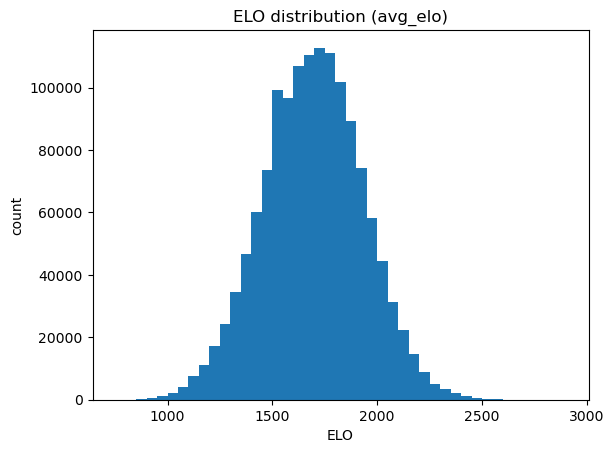

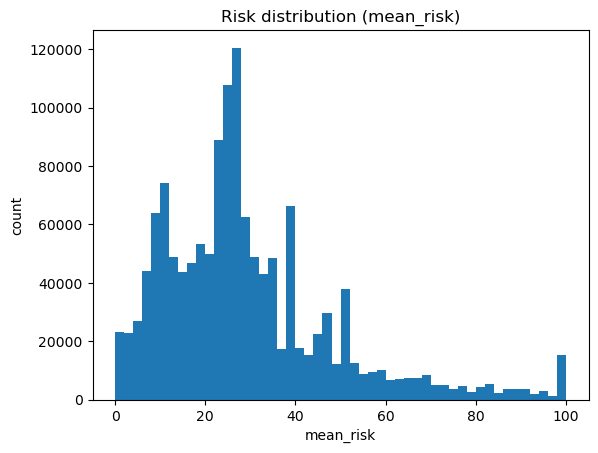

In [8]:
plt.figure()
plt.hist(df_c["white_rating"], bins=elo_bins)
plt.title("ELO distribution (avg_elo)")
plt.xlabel("ELO")
plt.ylabel("count")
plt.show()

risk_bins = np.arange(0, 101, 2)
plt.figure()
plt.hist(df_c["mean_risk"], bins=risk_bins)
plt.title("Risk distribution (mean_risk)")
plt.xlabel("mean_risk")
plt.ylabel("count")
plt.show()


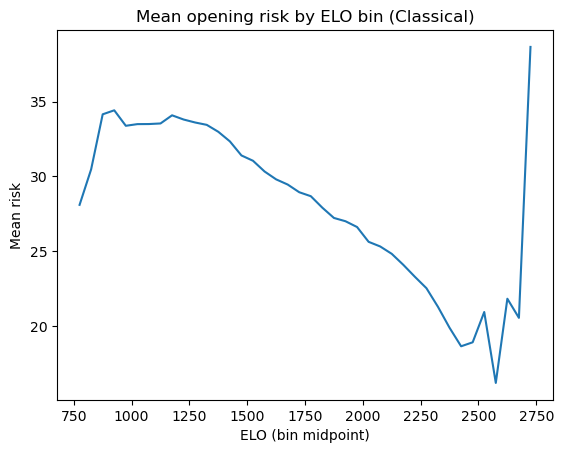

In [9]:
binned = df_c.groupby("elo_bin", observed=True)["mean_risk"].agg(["count", "mean", "median"]).reset_index()
binned["elo_mid"] = binned["elo_bin"].apply(lambda x: x.mid)

plt.figure()
plt.plot(binned["elo_mid"], binned["mean"])
plt.title("Mean opening risk by ELO bin (Classical)")
plt.xlabel("ELO (bin midpoint)")
plt.ylabel("Mean risk")
plt.show()

In [10]:
"""The line plot clearly shows that mean risk opening declines as ELO grows. From 750 to 1000 ELO, players play with high. 
But as ELO grows, players become more risk averse with their openings. At the very highest ELO bins the curve becomes noticeably 
jagged and ends with an extreme spike, which is most consistent with those bins containing far fewer games"""

'The line plot clearly shows that mean risk opening declines as ELO grows. From 750 to 1000 ELO, players play with high. \nBut as ELO grows, players become more risk averse with their openings. At the very highest ELO bins the curve becomes noticeably \njagged and ends with an extreme spike, which is most consistent with those bins containing far fewer games'

In [11]:
"""Statistical Analysis

To formally test whether opening risk varies systematically with player expertise, we estimate a linear 
regression model relating opening risk to player ELO. While descriptive plots suggest that higher-rated 
players tend to choose less risky openings, regression analysis allows us to quantify this relationship, 
estimate its magnitude, and assess whether it is statistically distinguishable from zero."""

'Statistical Analysis\n\nTo formally test whether opening risk varies systematically with player expertise, we estimate a linear \nregression model relating opening risk to player ELO. While descriptive plots suggest that higher-rated \nplayers tend to choose less risky openings, regression analysis allows us to quantify this relationship, \nestimate its magnitude, and assess whether it is statistically distinguishable from zero.'

In [16]:
def loglikelihood_lrm(alpha, beta, sigma_y, sample): # adapted from time series assignment
    sse = 0
    for x, y in sample:
        sse += (y - alpha - (beta * x))**2
    
    n = len(sample)
    log_likelihood = (-(n/2)*math.log(2*math.pi)) - (n*math.log(sigma_y)) - ((1/(2*(sigma_y**2))) * sse)
    return log_likelihood

def fit_lrm(sample): # adapted from time series assignment
    # First Search
    alphas = np.linspace(10, 50, 15)
    betas = np.linspace(-5, 5, 21)
    sigmas = np.linspace(5, 40, 15)

    best_params = (None, None, None)
    maximum = -math.inf

    for a in alphas:
        for b in betas:
            for sig in sigmas:
                candidate = loglikelihood_lrm(a, b, sig, sample)
                if candidate > maximum:
                    maximum = candidate
                    best_params = (a, b, sig)
    
    # Second Search - zooming in
    alpha1 = best_params[0]
    beta1 = best_params[1]
    sigma1 = best_params[2]

    alphas = np.linspace(alpha1 - 2, alpha1 + 2, 15)
    betas = np.linspace(beta1 - 1, beta1 + 1, 15)
    sigmas = np.linspace(max(0.01, sigma1 - 5), sigma1 + 5, 15) # Variance cant be negative

    for a in alphas:
        for b in betas:
            for sig in sigmas:
                candidate = loglikelihood_lrm(a, b, sig, sample)
                if candidate > maximum:
                    maximum = candidate
                    best_params = (a, b, sig)
    return best_params

# take a manageable subsample 
sample_df_c = df_c.sample(n=50_000, random_state=0)

# scale ELO to 100-point units
x = sample_df_c["white_rating"].to_numpy()/100
y = sample_df_c["mean_risk"].to_numpy()

paired_sample = list(zip(x, y))

alpha_hat, beta_hat, sigma_hat = fit_lrm(paired_sample)


print("alphâ:", alpha_hat)
print("betâ :", beta_hat, "(per 100 ELO)")
print("sigmâ:", sigma_hat)





alphâ: 46.28571428571429
betâ : -1.0 (per 100 ELO)
sigmâ: 19.285714285714285


In [17]:
def pearson_r(paired_sample):
    """
    Computes Pearson correlation coefficient r and r^2
    from a list of (X, Y) pairs.
    """

    # Extract X and Y
    X = [p[0] for p in paired_sample]
    Y = [p[1] for p in paired_sample]

    n = len(X)
    if n == 0:
        raise ValueError("Sample must contain at least one observation")

    # Means
    mean_X = sum(X) / n
    mean_Y = sum(Y) / n

    # Numerator: covariance part
    numerator = 0
    for i in range(n):
        x = X[i] - mean_X
        y = Y[i] - mean_Y
        numerator += x * y

    # Denominator: standard deviation parts
    den_x = sum((x - mean_X) ** 2 for x in X)
    den_y = sum((y - mean_Y) ** 2 for y in Y)

    if den_x == 0 or den_y == 0:
        raise ValueError("Zero variance in X or Y; correlation undefined")

    # Pearson correlation
    r = numerator / (den_x * den_y) ** 0.5

    return r, r**2

r, r2 = pearson_r(paired_sample)

print("r  =", r)
print("r² =", r2)

r  = -0.13032826477664958
r² = 0.01698545659969248


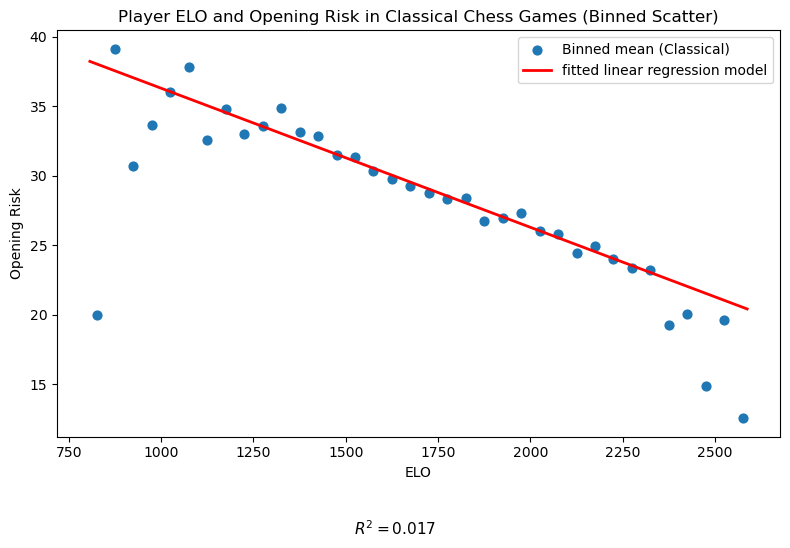

In [18]:
elo_line = np.linspace(x.min(), x.max(), 200)
risk_line = alpha_hat + beta_hat * (elo_line)

sample_df_c = sample_df_c.copy()
sample_df_c["elo_bin"] = pd.cut(
    sample_df_c["white_rating"],
    bins=elo_bins,
    include_lowest=True
)


# Aggregate
binned_sample = (
    sample_df_c
    .groupby("elo_bin", observed=True)["mean_risk"]
    .agg(["count", "mean"])
    .reset_index()
)

# Bin midpoints
binned_sample["elo_mid"] = binned_sample["elo_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(8,5))
plt.scatter(binned_sample["elo_mid"], binned_sample["mean"], s=40, label="Binned mean (Classical)")
plt.plot(elo_line * 100, risk_line, color='red', linewidth=2, label='fitted linear regression model')
plt.xlabel('ELO')
plt.ylabel('Opening Risk')
plt.title('Player ELO and Opening Risk in Classical Chess Games (Binned Scatter)')
plt.figtext(0.5, -0.08,f"$R^2 = {r2:.3f}$",ha="center", fontsize=11)
plt.legend()
plt.tight_layout()
plt.savefig("/Users/tonyvo/Desktop/SDA/final/Plots/elo_vs_risk_classical.png")
plt.show()


In [ ]:
# take a manageable subsample 
sample_df_b = df_b.sample(n=50_000, random_state=0)

# scale ELO to 100-point units
x = sample_df_b["white_rating"].to_numpy()/100
y = sample_df_b["mean_risk"].to_numpy()

paired_sample = list(zip(x, y))

alpha_hat, beta_hat, sigma_hat = fit_lrm(paired_sample)

r, r2 = pearson_r(paired_sample)


print("alphâ:", alpha_hat)
print("betâ :", beta_hat, "(per 100 ELO)")
print("sigmâ:", sigma_hat)

print("r  =", r)
print("r² =", r2)

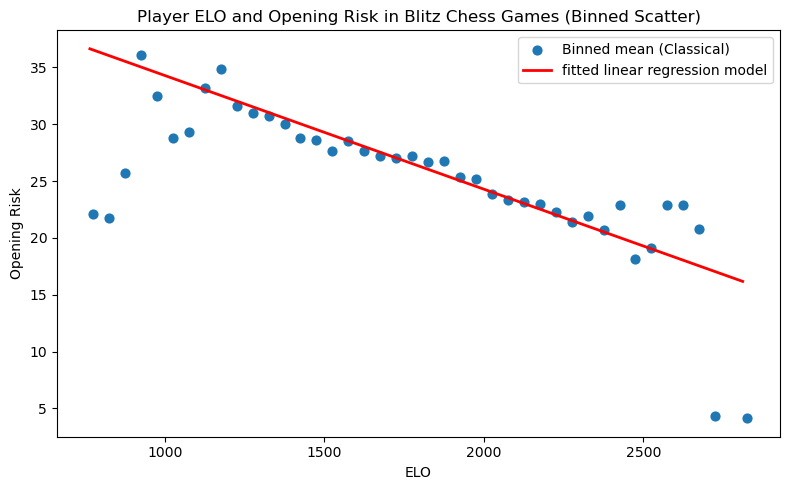

In [ ]:
elo_line = np.linspace(x.min(), x.max(), 200)
risk_line = alpha_hat + beta_hat * (elo_line)

sample_df_b = sample_df_b.copy()
sample_df_b["elo_bin"] = pd.cut(
    sample_df_b["white_rating"],
    bins=elo_bins,
    include_lowest=True
)


# Aggregate
binned_sample = (
    sample_df_b
    .groupby("elo_bin", observed=True)["mean_risk"]
    .agg(["count", "mean"])
    .reset_index()
)

# Bin midpoints
binned_sample["elo_mid"] = binned_sample["elo_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(8,5))
plt.scatter(binned_sample["elo_mid"], binned_sample["mean"], s=40, label="Binned mean (Classical)")
plt.plot(elo_line * 100, risk_line, color='red', linewidth=2, label='fitted linear regression model')
plt.xlabel('ELO')
plt.ylabel('Opening Risk')
plt.title('Player ELO and Opening Risk in Blitz Chess Games (Binned Scatter)')
plt.figtext(0.5, -0.08,f"$R^2 = {r2:.3f}$",ha="center", fontsize=11)
plt.legend()
plt.tight_layout()
plt.savefig("/Users/tonyvo/Desktop/SDA/final/Plots/elo_vs_risk_blitz.png")
plt.show()